In [1]:
![img](./images/Mayo_Clinic.Header.webp)

### Imports

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,\
    GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,\
    FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,\
    GradientBoostingClassifier, AdaBoostClassifier,\
    BaggingClassifier, ExtraTreesClassifier,\
    VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve

import xgboost

import pickle

from imblearn.pipeline import Pipeline as ImPipeline

#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
from sklearn.metrics import roc_curve
from numpy import sqrt, argmax

import model
from model import *

In [80]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

The 'import model' line is for a class ModelWithCV. 

In [4]:
# class ModelWithCV():
#     '''Structure to save the model and more easily see its crossvalidation'''
    
#     def __init__(self, model, model_name, X, y, cv_now=True):
#         self.model = model
#         self.name = model_name
#         self.X = X
#         self.y = y
#         # For CV results
#         self.cv_results = None
#         self.cv_mean = None
#         self.cv_median = None
#         self.cv_std = None
#         #
#         if cv_now:
#             self.cross_validate()
        
#     def cross_validate(self, X=None, y=None, kfolds=10):
#         '''
#         Perform cross-validation and return results.
        
#         Args: 
#           X:
#             Optional; Training data to perform CV on. Otherwise use X from object
#           y:
#             Optional; Training data to perform CV on. Otherwise use y from object
#           kfolds:
#             Optional; Number of folds for CV (default is 10)  
#         '''
        
#         cv_X = X if X else self.X
#         cv_y = y if y else self.y

#         self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
#         self.cv_mean = np.mean(self.cv_results)
#         self.cv_median = np.median(self.cv_results)
#         self.cv_std = np.std(self.cv_results)

        
# #     def print_cv_summary(self):
# #         cv_summary = (
# #         f'''CV Results for `{self.name}` model:
# #             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
# #             recall_score: {recall_score(self.y, self.model.predict(self.X))}
# #             precision_score: {precision_score(self.y, self.model.predict(self.X))}
# #             f1_score: {f1_score(self.y, self.model.predict(self.X))}    
# #         ''')
# #         print(cv_summary)
#     def print_cv_summary(self):
#         cv_summary = (
#         f'''CV Results for `{self.name}` model:
#             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
#             recall_score: {cross_val_score(self.model, self.X, self.y, cv=10, scoring='recall').mean()}
#             precision_score: {cross_val_score(self.model, self.X, self.y, cv=10, scoring='average_precision').mean()}
#             f1_score: {cross_val_score(self.model, self.X, self.y, cv=10, scoring='f1').mean()}    
#         ''')
#         print(cv_summary)
        
#     def plot_cv(self, ax):
#         '''
#         Plot the cross-validation values using the array of results and given 
#         Axis for plotting.
#         '''
#         ax.set_title(f'CV Results for `{self.name}` Model')
#         # Thinner violinplot with higher bw
#         sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
#         sns.swarmplot(
#                 y=self.cv_results,
#                 color='orange',
#                 size=10,
#                 alpha= 0.8,
#                 ax=ax
#         )

#         return ax

### Problem Description

The Mayo Clinic has tasked us with predicting how likely individuals are to receive the seasonal flu vaccine. 
We will concentrate on:
- Predicting who will get the seasonal vaccine?
- The most significant features in determining whether or not an individual will get vaccinated? 
- How can we get more people to get vaccinated?

### Data

The data was provided by DrivenData as a part of their competition. Details about the competition and getting the data can be found https://www.drivendata.org/competitions/66/flu-shot-learning/

The data was provided in two separate files, which were combined for cleaning splitting again later. 

In [5]:
training_set_features = pd.read_csv('../Data/training_set_features.csv')
training_set_labels = pd.read_csv('../Data/training_set_labels.csv')
complete_data = pd.merge(training_set_features, training_set_labels, on='respondent_id')

In [6]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

There are a considerable number of NA values in the dataset.

If the employment_status column has a value of Not in Labor Force, then columns employment_industry and employment_occupation will have NA's. 

Values in columns employment_industry and employment_occupation are represented as short random character strings. 

We will be filling NA's in employment_occupation and employment_industry associated with "Not in Labor Force" with because they would otherwise be imputed as the most frequent occupation or industry.

Filling Unemployed with "Not in Labor Force".

In [7]:
complete_data['employment_status'].replace("Unemployed", "Not in Labor Force", inplace=True)
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_industry'] = "Not in Labor Force"
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "Not in Labor Force"

In [8]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_occupation     1786
employment_industry       1646
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [9]:
complete_data['health_insurance'].value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

With the substantial number of NA's in Health Insurance we have decided to allow the simple imputer to fill in these NA's with the most frequent value.

#### Target Distribution

In [10]:
complete_data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

<span class="mark">Visualization</span>

### Split

Here we separated out our target variable 'seasonal_vaccine' and dropped 'respondent_id' and 'h1n1_vaccine'.

The 'values.ravel()' method reshapes y_train into a 1-D array.

In [11]:
X = complete_data.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y = complete_data.filter(['seasonal_vaccine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = y_train.values.ravel()

### Pipelines for Column Transformer

All columns are in a categorical format, however, some are scales and may better be represented as numeric columns.

Numeric columns include h1n1_concern, h1n1_knowledge, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, and opinion_seas_sick_from_vacc.

In [12]:
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',\
            'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',\
            'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
cat_cols = X.columns.drop(num_cols)

In [13]:
X[num_cols].describe()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
count,26615.000000,26591.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000
mean,1.618486,1.262532,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112
std,0.910311,0.618149,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000
50%,2.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
75%,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
max,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [14]:
X[num_cols].median()

h1n1_concern                   2.0
h1n1_knowledge                 1.0
opinion_h1n1_vacc_effective    4.0
opinion_h1n1_risk              2.0
opinion_h1n1_sick_from_vacc    2.0
opinion_seas_vacc_effective    4.0
opinion_seas_risk              2.0
opinion_seas_sick_from_vacc    2.0
dtype: float64

Because there are some missing values in the numeric columns, it is important determine the best measure of central tendency to replace these values. Because the values are scaler in nature we have decided to use the 'median' of each column to fill in these values.  

For categorical variables, the most frequent value for each column will be used to fill in the missing values.

In [15]:
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')) ])

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                              ('ss', StandardScaler()) ])

In [16]:
ct = ColumnTransformer(transformers = [
    ('subpipe_cat', subpipe_cat, cat_cols),
    ('subpipe_num', subpipe_num, num_cols)
])

### Models

Now that our Column Transformer pipeline has been created we can start running models.

#### Dummy Classifier

In [17]:
dummy_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(random_state=42))
])

In [18]:
dummy_model_pipe.fit(X_train, y_train);

In [19]:
dummy_model_pipe.score(X_train, y_train)

0.5310456603140893

In [20]:
dummy_pipe = ModelWithCV(dummy_model_pipe, model_name='dummy_pipe', X=X_train, y=y_train) #2s

In [21]:
dummy_pipe.print_cv_summary() #6s

CV Results for `dummy_pipe` model:
            0.53105 ± 0.00015 accuracy
            recall_score: 0.0
            precision_score: 0.46895434857961904
            f1_score: 0.0    
        


The 'print_cv_summary' function comes from the ModelWithCV class where the model runs a 10 fold cross validation to return accuracy, recall, precision, and f1 score.

Our dummy classifier predicts the most common value for the target value. It's accuracy is at about 53%.

#### Random Forest

In [33]:
rfc_model_pipe = Pipeline([('ct', ct), ('rfc', RandomForestClassifier(random_state=42))])

In [34]:
forest_pipe = ModelWithCV(rfc_model_pipe, 'forest_pipe', X_train, y_train) #14s

In [35]:
forest_pipe.print_cv_summary() #44s

CV Results for `forest_pipe` model:
            0.76974 ± 0.00926 accuracy
            recall_score: 0.7372197627561156
            precision_score: 0.8197726242046623
            f1_score: 0.7501871236786735    
        


##### Random Forest  Tuned

Our Grid Search determined the optimal parameters for Random Forest was max_features= 'sqrt' and n_estimators= 1000.

In [36]:
import pickle
with open('tuned_forest.sav', 'rb') as f:
    tforest = pickle.load(f)
tforest

In [37]:
tforest.print_cv_summary() #6m 34s

CV Results for `tforest_pipe` model:
            0.77729 ± 0.01016 accuracy
            recall_score: 0.748303677847778
            precision_score: 0.827178576571227
            f1_score: 0.7591233315229753    
        


#### Gradient Booster

Has feature_importances.

In [38]:
gbc_model_pipe = Pipeline([('ct', ct), ('gbc', GradientBoostingClassifier(random_state=42))])

In [39]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train) #24s

KeyboardInterrupt: 

In [ ]:
boost_pipe.print_cv_summary() #1m 13s

#####  Gradient Booster Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was learning_rate = 0.05 and n_estimators = 350.

In [ ]:
import pickle
with open('tuned_gboost.sav', 'rb') as f:
    tgboost = pickle.load(f)
tgboost

In [ ]:
tgboost.print_cv_summary() #4m

#### AdaBoost

Has feature_importances.

In [ ]:
ada_model_pipe = Pipeline([('ct', ct), ('ada', AdaBoostClassifier(random_state=42))])

In [ ]:
ada_pipe = ModelWithCV(model=ada_model_pipe,
                         model_name='ada_pipe',
                         X=X_train,
                         y=y_train) #8s

In [ ]:
ada_pipe.print_cv_summary() #24s

#####  AdaBoost Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was learning_rate = 0.75 and n_estimators = 350.

In [ ]:
import pickle
with open('tuned_ada.sav', 'rb') as f:
    tada = pickle.load(f)
tada

In [ ]:
tada.print_cv_summary() #2m 10s

#### XGBoost

Has feature_importances.

In [ ]:
xgb_model_pipe = Pipeline([('ct', ct), ('xgb', xgboost.XGBClassifier(random_state=42, n_jobs=-1))])

In [ ]:
xgb_pipe = ModelWithCV(model=xgb_model_pipe,
                         model_name='xgb_pipe',
                         X=X_train,
                         y=y_train) #1m 9s

In [ ]:
xgb_pipe.print_cv_summary() #3m 30s

#####  XGBoost Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was learning_rate = 0.05 and n_estimators = 150.

In [ ]:
import pickle
with open('tuned_xgb.sav', 'rb') as f:
    txboost = pickle.load(f)
txboost

In [ ]:
txboost.print_cv_summary() #16m

#### Extra Trees Classifier

In [40]:
etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_model_pipe = Pipeline([('ct', ct), ('etc', etc)])

In [41]:
etc_pipe = ModelWithCV(model=etc_model_pipe,
                         model_name='etc_pipe',
                         X=X_train,
                         y=y_train) #10s

In [42]:
etc_pipe.print_cv_summary() #29s

CV Results for `etc_pipe` model:
            0.77047 ± 0.01051 accuracy
            recall_score: 0.7311413814631933
            precision_score: 0.81660908330488
            f1_score: 0.7492093931985719    
        


#####  Extra Trees Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was max_depth = 50 and n_estimators = 500.

In [43]:
import pickle
with open('tuned_etc.sav', 'rb') as f:
    tetc = pickle.load(f)
tetc

In [44]:
tetc.print_cv_summary() #1m 53s

CV Results for `tetc_pipe` model:
            0.77489 ± 0.00958 accuracy
            recall_score: 0.7441316192746468
            precision_score: 0.823900961528032
            f1_score: 0.7561029997599423    
        


### Ensembles

In [45]:
with open('avg1_model.sav', 'rb') as f:
    avg1_model = pickle.load(f)
avg1_model

/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


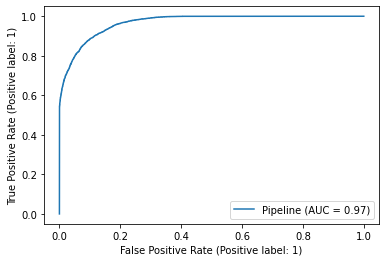

In [46]:
plot_roc_curve(avg1_model.model.fit(X_train, y_train), X_train, y_train);

In [59]:
with open('avg2_model.sav', 'rb') as f:
    avg2_model = pickle.load(f)
avg2_model

/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


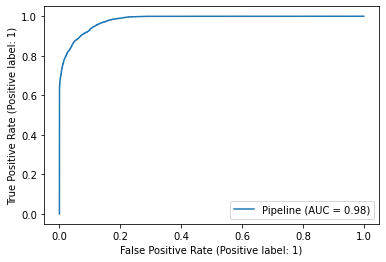

In [48]:
plot_roc_curve(avg2_model.model.fit(X_train, y_train), X_train, y_train);

### Feature Importance

In [60]:
ohe_col_names = avg2_model.model.named_steps['ct'].named_transformers_['subpipe_cat']['ohe'].get_feature_names_out()

ohe_cat_cols = ohe_col_names.tolist()

In [61]:
post_ct_cols = ohe_cat_cols + num_cols

In [62]:
avg2_model.model.fit(X_train, y_train); #22s

In [63]:
X_post = pd.DataFrame(avg2_model.model.named_steps['ct'].fit_transform(X_train, y_train), columns=post_ct_cols)

In [64]:
for alg in avg2_model.model.named_steps['avg2'].named_estimators:
    clf = avg2_model.model.named_steps['avg2'].named_estimators[alg]
    feat_imp = clf.fit(X_post, y_train).feature_importances_

array([0.00559583, 0.01384104, 0.00702723, 0.01125046, 0.01470345,
       0.01472596, 0.01501676, 0.01826545, 0.07078256, 0.01834391,
       0.00763034, 0.01094182, 0.00783352, 0.00896935, 0.01040221,
       0.01231508, 0.03817693, 0.00776988, 0.01480412, 0.01324032,
       0.00551027, 0.00556485, 0.01269068, 0.0162847 , 0.01329535,
       0.00830525, 0.01504449, 0.01292015, 0.01290722, 0.00979126,
       0.00518444, 0.01045645, 0.00969131, 0.00820989, 0.01182975,
       0.00793796, 0.01006926, 0.01014857, 0.01532041, 0.01485817,
       0.0153816 , 0.00866513, 0.00474388, 0.00953193, 0.00822701,
       0.00673592, 0.0043763 , 0.00387031, 0.00185741, 0.00117665,
       0.00791773, 0.0027475 , 0.00449358, 0.00138827, 0.00334809,
       0.00095766, 0.00138239, 0.00073167, 0.00379962, 0.00012873,
       0.0023524 , 0.00163796, 0.00272179, 0.00122913, 0.00561963,
       0.00326804, 0.00262185, 0.00220803, 0.00190608, 0.00500295,
       0.00262399, 0.00136398, 0.00447007, 0.00139809, 0.00372

In [65]:
A = pd.DataFrame()
A['Features'] = post_ct_cols
A['Feature_importance'] = feat_imp
A.sort_values('Feature_importance', ascending=False).head(10)

,Features,Feature_importance
96,opinion_seas_risk,0.077719
8,x8_1.0,0.070783
95,opinion_seas_vacc_effective,0.063986
16,x13_65+ Years,0.038177
93,opinion_h1n1_risk,0.029296
92,opinion_h1n1_vacc_effective,0.028085
97,opinion_seas_sick_from_vacc,0.025293
90,h1n1_concern,0.024303
94,opinion_h1n1_sick_from_vacc,0.022303
91,h1n1_knowledge,0.021431


x8_1.0 = Behavior outside of Home

<span class="mark">Visualization.</span>

### Final Model

In [66]:
final_model = avg2_model.model

In [67]:
final_model.fit(X_train, y_train); 

/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


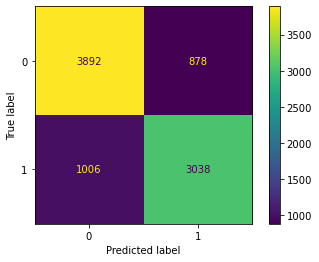

In [68]:
fm1_cm = plot_confusion_matrix(final_model, X_test, y_test);

In [70]:
y_hat = final_model.predict(X_test) 

In [72]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.75 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.76.



/Users/zachrauch/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


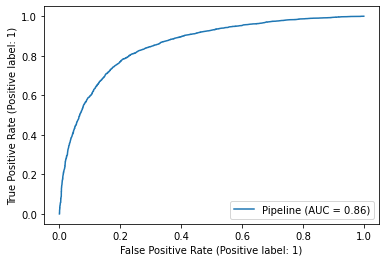

In [73]:
fm1_roc_curve = plot_roc_curve(final_model, X_test, y_test)

In [75]:
y_hat = final_model.predict_proba(X_test)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.478000, G-Mean=0.787


In [76]:
y_hat = (final_model.predict_proba(X_test)[:,1] >= thresholds[ix]).astype(bool) 

In [79]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.78 

Our final model's precision on the test set is 0.76 

Our final model's f1-score on the test is 0.77.



<span class="mark">Visualization.</span>

Part 2

In [81]:
with open('avg3_model.sav', 'rb') as f:
    avg3_model = pickle.load(f)
avg3_model

In [82]:
final_model = avg3_model.model

In [83]:
final_model.fit(X_train, y_train); 

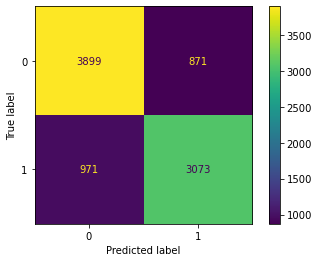

In [84]:
fm1_cm = plot_confusion_matrix(final_model, X_test, y_test);

In [85]:
y_hat = final_model.predict(X_test) 

In [86]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.76 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.77.



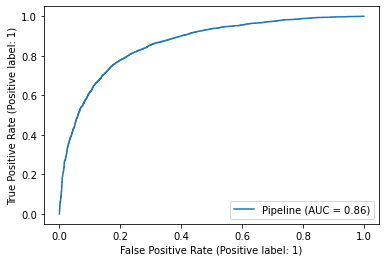

In [87]:
fm1_roc_curve = plot_roc_curve(final_model, X_test, y_test)

In [88]:
y_hat = final_model.predict_proba(X_test)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.486700, G-Mean=0.790


In [89]:
y_hat = (final_model.predict_proba(X_test)[:,1] >= thresholds[ix]).astype(bool) 

In [90]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.78 

Our final model's precision on the test set is 0.77 

Our final model's f1-score on the test is 0.77.



### Next Steps

With more time we could run and tune more models. More and better models could improve our models performance.